# INFORMACIÓN DEL PROYECTO

Tratamos de averiguar qué variables inciden en si un préstamo va a ser impagado


### HIPÓTESIS

La hipótesis de la que partimos es que existen variables que permiten explicar la probabilidad de que un préstamo resulte impagado. 

En concreto partimos de datasets cuyo origen está en el reconocido "All Lending Club loan data" que recopila información sobre diversas variables de préstamos de USA. En Kaggle existe información hasta 2018 (https://www.kaggle.com/datasets/wordsforthewise/lending-club). Para obtener información más actualizada, habría que ser miembro del Club y obtenerla directamente (https://www.lendingclub.com/). Sin emabrgo, dada la longitud y tamaño de la base de datos (más de 1 GB) usaremos un dataset más reducido con datos de 2012 y que usan, a modo de ejemplo, para el servicio SageMaker de Amazon Web Services (AWS).

Los datos se componen de 2 dataset en formato csv con las siguientes columnas.

Dataset 1:

* id: número de identificación del préstamo
* loan_status: estado actual del préstamo (normalmente 3 estados: fully paid, charged off, current)
* loan_amount: importe concedido del préstamo
* funded_amount_by_investors: monto recibido efectivamente por el prestatario (deducidas las comisiones de apertura)
* loan_term: número de pagos del préstamo en meses (36 o 60)
* interest_rate: tipo de interés del préstamo
* installment: cuota mensual del préstamo
* grade: grado clasificación dado por LC (Lending Club)
* subgrade: subgrado otorgado por LC
* verification_status: indica si los ingresos del prestatario han sido verificados por LC
* issued_on: fecha de emisión del préstamo
* purpose: propósito del préstamo (coche, negocio, tarjeta, etc)
* dti: ratio que divide el pago total de cuotas en préstamos del prestatario sobre el total de ingresos mensuales, excluyendo el pago de la hipoteca.
* inquiries_last_six_months: númeo de consultas del prestatario en los últimos 6 meses
* open_credit_lines: número de préstamos del prestatario abiertas.
* derogatory_public_records: número de registros públicos negativos
* revolving_line_utilization_rate: tasa de uso de crédito en tarjetas revolving
* total_credit_lines: total de créditos del pretatario en la base de datos

Dataset 2:

* id: número de identificación del préstamo
* employment_length: tiempo que el prestario ha estado trabajando en años (entre 0 y 10, si es más se le asigna 10)
* employer_title: nombre del empleo del prestatario
* home_ownership: (own= vivienda en propiedad, rent: alquilada)
* annual_income: ingresos anuales del prestatario

Ambos dataset tienen 39717 filas de datos

#### Hipótesis de nuestro proyecto

En nuestro poyecto nos centraremos en averiguar si puede predecirse el pago o impago de un préstamo a partir de las variables mencionadas en el dataset.


## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

Los datos están disponibles en la web del servicio de Amazon SageMaker de AWS como ejemplo para la demostración de sus servicios.

En concreto las url de cada dataset son las siguientes:

[Dataset 1](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-1.csv)

[Dataset 2](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-2.csv)

Empezamos importando las librerías que vamos a necesitar

In [115]:
# Importamos las librerías Python que vamos a necesitar en nuestro estudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



import sys
sys.path.append('../')
from utils.eda_functions import *

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


In [30]:
# %run ../train.py

Empezamos viendo el contenido de cada uno de los dataset (columnas, tipo de datos en cada columna, posible existencia de valores nulos o el número de filas de cada dataset)

In [2]:
df_1 = pd.read_csv('../data/raw/loans-part-1.csv')
df_2 = pd.read_csv('../data/raw/loans-part-2.csv')

In [3]:
df_1.shape

(39717, 18)

In [4]:
df_2.shape

(39717, 5)

In [5]:
df_1.columns

Index(['id', 'loan_status', 'loan_amount', 'funded_amount_by_investors',
       'loan_term', 'interest_rate', 'installment', 'grade', 'sub_grade',
       'verification_status', 'issued_on', 'purpose', 'dti',
       'inquiries_last_6_months', 'open_credit_lines',
       'derogatory_public_records', 'revolving_line_utilization_rate',
       'total_credit_lines'],
      dtype='object')

In [6]:
df_2.columns

Index(['id', 'employment_length', 'employer_title', 'home_ownership',
       'annual_income'],
      dtype='object')

De este primer análisis, parece inferirse que el dataset 2 es una continuación del dataset 1, y que parece tener los mismos id. 

Comprobamos que las columnas id de ambos dataset son iguales

In [7]:
if df_1.index.equals(df_2.index):
    print('Ambos dataset tienen exactamente los mismos índices')
else:
    print('Los dataset no tienen los mismos índices')

Ambos dataset tienen exactamente los mismos índices


Comprobado que efectivamente ambos dataset tienen los mismos índices, procedemos a hacer un merge de los mismos para trabajar con un solo Dataframe

In [8]:
df_original = df_1.merge(df_2, on='id')
df_original.head(5)

,id,loan_status,loan_amount,funded_amount_by_investors,loan_term,interest_rate,installment,grade,sub_grade,verification_status,issued_on,purpose,dti,inquiries_last_6_months,open_credit_lines,derogatory_public_records,revolving_line_utilization_rate,total_credit_lines,employment_length,employer_title,home_ownership,annual_income
0,1077501,fully paid,5000,4975.0,36,10.65,162.87,b,b2,verified,2011-12-01,credit_card,27.65,1,3,0,83.7,9,10.0,NaN,rent,24000.0
1,1077430,charged off,2500,2500.0,60,15.27,59.83,c,c4,source verified,2011-12-01,car,1.00,5,3,0,9.4,4,1.0,ryder,rent,30000.0
2,1077175,fully paid,2400,2400.0,36,15.96,84.33,c,c5,not verified,2011-12-01,small_business,8.72,2,2,0,98.5,10,10.0,NaN,rent,12252.0
3,1076863,fully paid,10000,10000.0,36,13.49,339.31,c,c1,source verified,2011-12-01,other,20.00,1,10,0,21.0,37,10.0,air resources board,rent,49200.0
4,1075358,current,3000,3000.0,60,12.69,67.79,b,b5,source verified,2011-12-01,other,17.94,0,15,0,53.9,38,1.0,university medical group,rent,80000.0


Vemos algunos datos de este dataset.

In [9]:
df_original.to_csv('../data/processed/df_original.csv', index=False)

In [10]:
df_original.shape

(39717, 22)

In [11]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39717 non-null  int64  
 1   loan_status                      39717 non-null  object 
 2   loan_amount                      39717 non-null  int64  
 3   funded_amount_by_investors       39717 non-null  float64
 4   loan_term                        39717 non-null  int64  
 5   interest_rate                    39717 non-null  float64
 6   installment                      39717 non-null  float64
 7   grade                            39717 non-null  object 
 8   sub_grade                        39717 non-null  object 
 9   verification_status              39717 non-null  object 
 10  issued_on                        39717 non-null  object 
 11  purpose                          39717 non-null  object 
 12  dti               

Veamos la cardinalidad de las variables no numéricas

In [12]:
for i in df_original.select_dtypes(include='object'):
    print(f"La cardinalidad de la variable {i} es {(df_original[i].nunique()/df_original.shape[0])*100:.2f}%")

La cardinalidad de la variable loan_status es 0.01%
La cardinalidad de la variable grade es 0.02%
La cardinalidad de la variable sub_grade es 0.09%
La cardinalidad de la variable verification_status es 0.01%
La cardinalidad de la variable issued_on es 0.14%
La cardinalidad de la variable purpose es 0.04%
La cardinalidad de la variable employer_title es 68.51%
La cardinalidad de la variable home_ownership es 0.01%


Comprobemos que no hay duplicados en nuestros datos. 

In [13]:
df_original.duplicated().sum()

0

Más características de nuestro dataset

En principio, vamos a eliminar las siguientes columnas de nuestro análisis por las siguientes causas. En concreto son las siguientes:

* 'funded_amount_by_investors": no es más que el importe del préstamo deduciendo las comisiones. Es una variable fuertemente correlacionada con "loan_amount" Nos quedamos con el importe total del préstamo
* 'issued_on': fecha de emisión del préstamo. Es indiferente a nuestro análisis la fecha en la que el préstamo se aprobó.
* 'employer_title': sector del empleador. Es una variable categórica con mucha cardinalidad, sin que podamos extraer información de ella, por lo que no es práctico su análisis.
* 'sub_grade', es una subdivisión de la variable 'grade'

Por otro lado, comprobamos los valores de la columna objeto de todos los estudios que es 'loan_status'

In [14]:
df_original['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

Cómo vemos, esta columna tiene 3 posibles valores:
* 'fully_paid': El préstamo ha sido pagado por completo.
* 'charged_off': el préstamo está en una situación de impagado.
* 'current': El préstamo está vigente



In [15]:
columnas_eliminar = ['funded_amount_by_investors', 'issued_on', 'employer_title', 'sub_grade']

df = df_original.copy()
df = df.drop(columnas_eliminar, axis=1)
df.rename(columns={'revolving_line_utilization_rate': 'revolving_rate', 'inquiries_last_6_months': 'inquiries', 'derogatory_public_records': 'derogatory'}, inplace=True)

df.head(10)


,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,fully paid,5000,36,10.65,162.87,b,verified,credit_card,27.65,1,3,0,83.7,9,10.0,rent,24000.0
1,1077430,charged off,2500,60,15.27,59.83,c,source verified,car,1.00,5,3,0,9.4,4,1.0,rent,30000.0
2,1077175,fully paid,2400,36,15.96,84.33,c,not verified,small_business,8.72,2,2,0,98.5,10,10.0,rent,12252.0
3,1076863,fully paid,10000,36,13.49,339.31,c,source verified,other,20.00,1,10,0,21.0,37,10.0,rent,49200.0
4,1075358,current,3000,60,12.69,67.79,b,source verified,other,17.94,0,15,0,53.9,38,1.0,rent,80000.0
5,1075269,fully paid,5000,36,7.90,156.46,a,source verified,wedding,11.20,3,9,0,28.3,12,3.0,rent,36000.0
6,1069639,fully paid,7000,60,15.96,170.08,c,not verified,debt_consolidation,23.51,1,7,0,85.6,11,8.0,rent,47004.0
7,1072053,fully paid,3000,36,18.64,109.43,e,source verified,car,5.35,2,4,0,87.5,4,9.0,rent,48000.0
8,1071795,charged off,5600,60,21.28,152.39,f,source verified,small_business,5.55,2,11,0,32.6,13,4.0,own,40000.0
9,1071570,charged off,5375,60,12.69,121.45,b,verified,other,18.08,0,2,0,36.5,3,1.0,rent,15000.0


Así, ya tenemos un dataframe con las columnas que nos interesa y con dos 'loan_status' que nos interesa. Tenemos también otro Dataframe llamado df_current_final con datos de los préstamos vigentes.

Pasamos a hacer un estudio más detallado de las variables de este dataset.

In [16]:
df.shape

(39717, 18)

In [17]:
data_report(df)

COL_N,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
DATA_TYPE,int64,object,int64,int64,float64,float64,object,object,object,float64,int64,int64,int64,float64,int64,float64,object,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13,0.0,2.71,0.0,0.0
UNIQUE_VALUES,39717,3,885,2,371,15383,7,3,14,2868,9,40,5,1089,82,10,5,5318
CARDIN (%),100.0,0.01,2.23,0.01,0.93,38.73,0.02,0.01,0.04,7.22,0.02,0.1,0.01,2.74,0.21,0.03,0.01,13.39


Podemos observar que las columnas 'employment_length' y 'revolving_rate' contiene valores nulos

In [18]:
df.describe(exclude='object').round(2)

,id,loan_amount,loan_term,interest_rate,installment,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39667.00,39717.00,38642.00,39717.00
mean,683131.91,11219.44,42.42,12.02,324.56,13.32,0.87,9.29,0.06,48.83,22.09,5.09,68968.93
std,210694.13,7456.67,10.62,3.72,208.87,6.68,1.07,4.40,0.24,28.33,11.40,3.41,63793.77
min,54734.00,500.00,36.00,5.42,15.69,0.00,0.00,2.00,0.00,0.00,2.00,1.00,4000.00
25%,516221.00,5500.00,36.00,9.25,167.02,8.17,0.00,6.00,0.00,25.40,13.00,2.00,40404.00
50%,665665.00,10000.00,36.00,11.86,280.22,13.40,1.00,9.00,0.00,49.30,20.00,4.00,59000.00
75%,837755.00,15000.00,60.00,14.59,430.78,18.60,1.00,12.00,0.00,72.40,29.00,9.00,82300.00
max,1077501.00,35000.00,60.00,24.59,1305.19,29.99,8.00,44.00,4.00,99.90,90.00,10.00,6000000.00


In [19]:
df.describe(include='object')

,loan_status,grade,verification_status,purpose,home_ownership
count,39717,39717,39717,39717,39717
unique,3,7,3,14,5
top,fully paid,b,not verified,debt_consolidation,rent
freq,32950,12020,16921,18641,18899


Veamos más detalles de las columnas 'loan_status' y otras variables

La variable 'loan_status' va a ser nuestra variable objetivo.

In [20]:
df['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

In [21]:
df['loan_status'].value_counts(normalize=True).mul(100).round(2)

loan_status
fully paid     82.96
charged off    14.17
current         2.87
Name: proportion, dtype: float64

Como vemos, aunque el dataset está algo balanceado, hay suficiente representación de cada uno de los valores como para que no necesitemos aplicar técnicas de desbalanceo

En la columna "employment_length", tenemos que hacer la precisión de que los empleados con 10 años de antigüedad son en realidad de 10 o más años de antigüedad

## Limpieza de datos

### Sustitución de valores nulos

Vamos a analizar ahora las columnas con valores faltantes, en nuestro caso, 'revolving_rate' y 'employment_length'. En el primer caso son 50 de 39.717 filas (0,12%). En el segundo caso son 1.075 de 39.717 (2,71 %)

In [22]:
df.isna().sum() / len(df) * 100

id                     0.000000
loan_status            0.000000
loan_amount            0.000000
loan_term              0.000000
interest_rate          0.000000
installment            0.000000
grade                  0.000000
verification_status    0.000000
purpose                0.000000
dti                    0.000000
inquiries              0.000000
open_credit_lines      0.000000
derogatory             0.000000
revolving_rate         0.125891
total_credit_lines     0.000000
employment_length      2.706650
home_ownership         0.000000
annual_income          0.000000
dtype: float64

Tenemos muchos datos con el valor 'revolving_rate' = 0 (es decir, que el prestatario no ha incurrido en 'revolving)

In [23]:
df['revolving_rate'].value_counts(normalize=True, dropna=True).mul(100).round(2).sort_values

<bound method Series.sort_values of revolving_rate
0.00     2.46
0.20     0.16
63.00    0.16
40.70    0.15
66.70    0.15
         ... 
25.74    0.00
47.36    0.00
24.65    0.00
10.61    0.00
7.28     0.00
Name: proportion, Length: 1089, dtype: float64>

Vamos a imputar a los valores Nan de la columna 'revolving_rate' el valor 0

In [24]:
df['revolving_rate'] = df['revolving_rate'].fillna(0)

En cuanto a la columna 'employment_lenth', veamos un gráfico con su distribución de valores

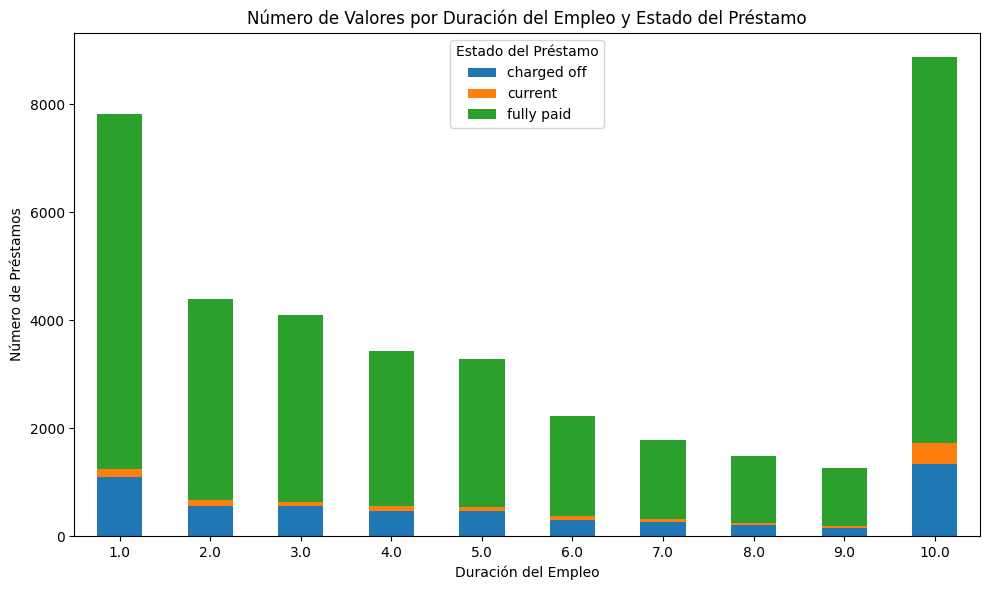

In [25]:
# Valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', dropna=True)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Número de Préstamos')
plt.title('Número de Valores por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()

En porcentajes por tipo sobre el total

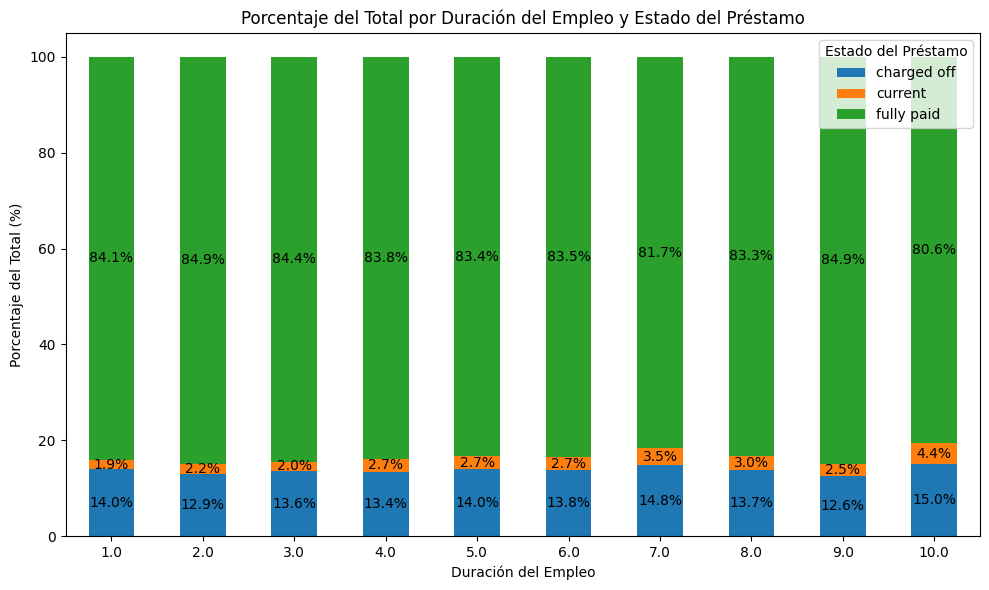

In [26]:
# Conteo de valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', fill_value=0)

# Calcular los porcentajes
totals = pivot_df.sum(axis=1)
percentage_df = pivot_df.div(totals, axis=0) * 100

# Crear el gráfico de barras apiladas con porcentajes y etiquetas
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Porcentaje del Total (%)')
plt.title('Porcentaje del Total por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Agregar etiquetas con los porcentajes a las barras
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Veamos ahora un dataset con los datos de 'employment_length' Nan, para ver si podemos establecer algún criterio para asignar estos valores.

In [27]:
df[df['employment_length'].isna()].head(10)

,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
168,1067644,charged off,2500,36,7.51,77.78,a,source verified,debt_consolidation,16.30,2,13,0,42.2,20,NaN,own,12000.0
323,1058717,fully paid,18000,60,17.58,452.98,d,verified,debt_consolidation,21.96,1,11,0,83.7,28,NaN,mortgage,60000.0
394,1064582,fully paid,4000,36,11.71,132.31,b,source verified,home_improvement,7.50,0,4,0,54.9,6,NaN,rent,24000.0
422,1064366,charged off,1000,36,14.65,34.50,c,not verified,major_purchase,6.00,2,3,1,83.7,8,NaN,rent,18408.0
439,1063912,fully paid,8250,36,7.51,256.67,a,verified,debt_consolidation,17.87,4,17,0,10.4,37,NaN,mortgage,31500.0
534,1062897,charged off,1700,36,7.90,53.20,a,not verified,home_improvement,27.00,0,9,0,91.2,27,NaN,mortgage,37800.0
555,1062781,fully paid,5000,36,8.90,158.77,a,source verified,other,16.17,0,9,0,53.0,32,NaN,mortgage,70000.0
562,1062535,fully paid,3000,36,9.91,96.68,b,not verified,renewable_energy,4.29,0,3,0,33.3,3,NaN,mortgage,42000.0
569,1036838,charged off,8575,36,17.58,308.21,d,verified,debt_consolidation,22.54,1,4,0,89.9,5,NaN,mortgage,32000.0
678,1061194,fully paid,5600,36,6.03,170.44,a,not verified,car,3.97,0,17,0,2.7,44,NaN,own,41100.0


No parece haber un criterio claro para asignar los Nan de esta columna. Ya que representan un porcentaje pequeño de nuestro dataset, vamos a proceder a eliminarlos.

In [28]:
df.dropna(subset=['employment_length'], inplace=True)

### Búsqueda y sustitución de outliers

El siguiente paso es buscar posibles outliers o valores atípicos. Para detectar posibles valores atípicos usamos gráficos de tipo boxplot, en las variables que sean cuantitativas contínuas.

Vemos los valores únicos de cada columna

In [29]:
for columna in df.columns:
    num_valores_unicos = df[columna].nunique()
    print(f"La columna '{columna}' tiene {num_valores_unicos} valores únicos.")

La columna 'id' tiene 38642 valores únicos.
La columna 'loan_status' tiene 3 valores únicos.
La columna 'loan_amount' tiene 880 valores únicos.
La columna 'loan_term' tiene 2 valores únicos.
La columna 'interest_rate' tiene 371 valores únicos.
La columna 'installment' tiene 15149 valores únicos.
La columna 'grade' tiene 7 valores únicos.
La columna 'verification_status' tiene 3 valores únicos.
La columna 'purpose' tiene 14 valores únicos.
La columna 'dti' tiene 2863 valores únicos.
La columna 'inquiries' tiene 9 valores únicos.
La columna 'open_credit_lines' tiene 40 valores únicos.
La columna 'derogatory' tiene 5 valores únicos.
La columna 'revolving_rate' tiene 1087 valores únicos.
La columna 'total_credit_lines' tiene 82 valores únicos.
La columna 'employment_length' tiene 10 valores únicos.
La columna 'home_ownership' tiene 5 valores únicos.
La columna 'annual_income' tiene 5100 valores únicos.


In [30]:
columnas_continuas = []

for columna in df.columns:
    if df[columna].nunique() > 100:
        columnas_continuas.append(columna)

        

In [31]:
columnas_continuas.remove('id')
columnas_continuas

['loan_amount',
 'interest_rate',
 'installment',
 'dti',
 'revolving_rate',
 'annual_income']

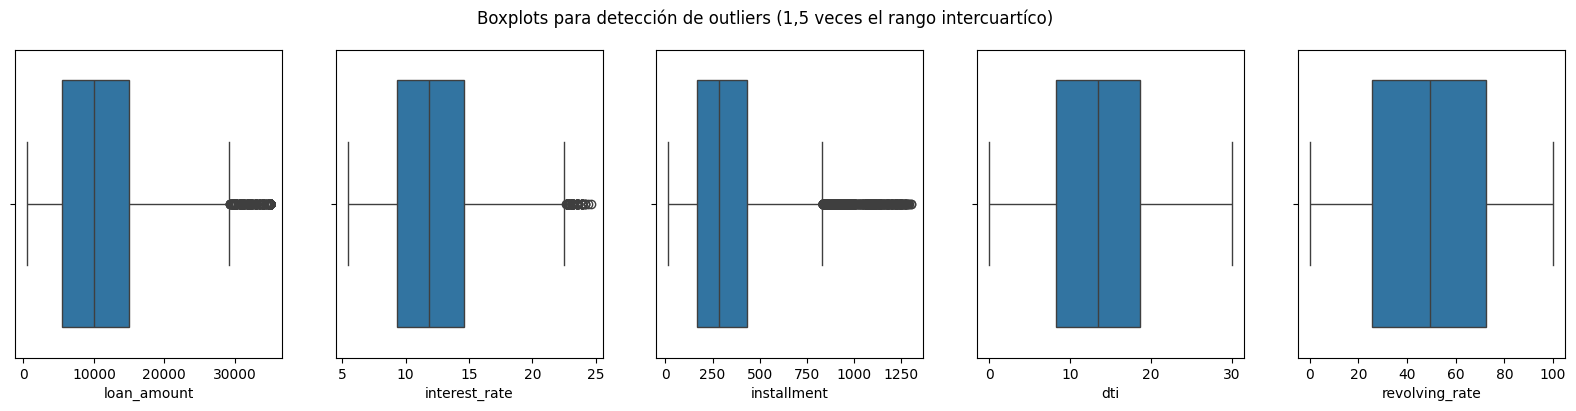

In [32]:
# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (1,5 veces el rango intercuartíco)')
sns.boxplot(ax=axes[0], x=df[columnas_continuas[0]])
sns.boxplot(ax=axes[1], x=df[columnas_continuas[1]])
sns.boxplot(ax=axes[2], x=df[columnas_continuas[2]])
sns.boxplot(ax=axes[3], x=df[columnas_continuas[3]])
sns.boxplot(ax=axes[4], x=df[columnas_continuas[4]])
plt.show();

Por la gráfica, vemos que tanto las columnas 'dti' o 'revolving_rate' no tiene outliers apreciables. Las otras 3 columnas, y sobre todo la columna 'annual_income' parecen tener elevados valores fuera del rango del 1,5 * rango intercuartílico

In [33]:
df[columnas_continuas].describe().round(2)

,loan_amount,interest_rate,installment,dti,revolving_rate,annual_income
count,38642.00,38642.00,38642.00,38642.00,38642.00,38642.00
mean,11291.62,12.05,326.76,13.33,48.94,69608.28
std,7462.14,3.72,209.14,6.67,28.34,64253.20
min,500.00,5.42,15.69,0.00,0.00,4000.00
25%,5500.00,9.32,168.44,8.20,25.50,41400.00
50%,10000.00,11.86,282.83,13.42,49.50,60000.00
75%,15000.00,14.59,434.40,18.59,72.50,83199.99
max,35000.00,24.59,1305.19,29.99,99.90,6000000.00


Vamos a volver a realizar un gráfico boxplot para las columnas 'loan_amount', 'interest_rate' y 'annual_income', pero tomando con outliers la cantidad de 6 veces el rango intercuartílico, a fin de disminuir la cantidad de valores que dejamos fuera como consecuencia de tomar el 1,5 * rango intercuartílico

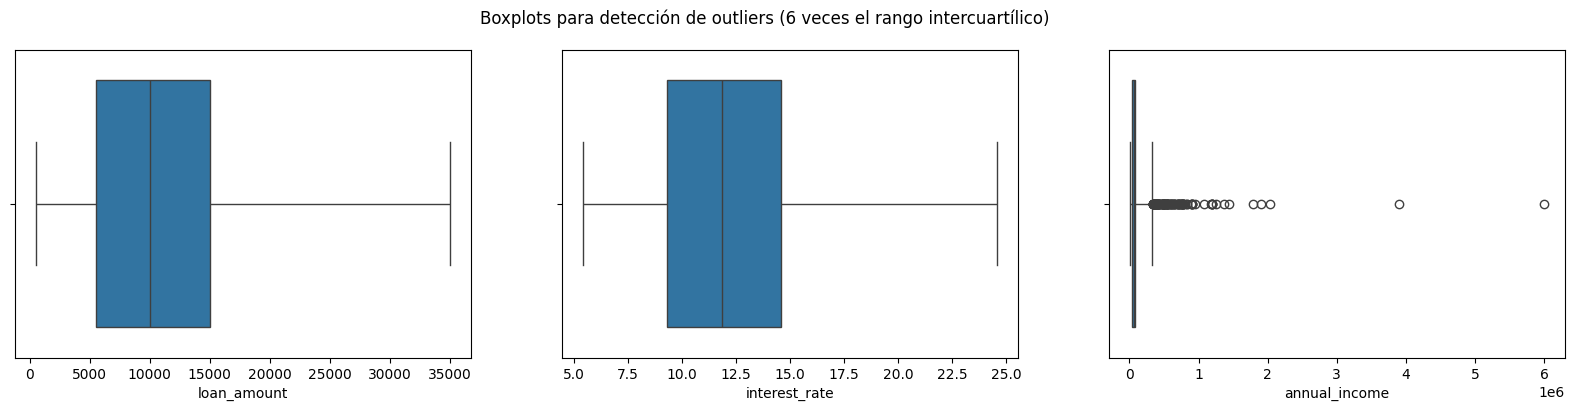

In [34]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas_2 = ['loan_amount', 'interest_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (6 veces el rango intercuartílico)')
sns.boxplot(ax=axes[0], x=df[columnas_continuas_2[0]], whis=6)
sns.boxplot(ax=axes[1], x=df[columnas_continuas_2[1]], whis=6)
sns.boxplot(ax=axes[2], x=df[columnas_continuas_2[2]], whis=6)

plt.show();

Aumentando a 3 las veces del rango intercuartílico para considerar un valor como outlier resolvemos la existencia de outliers en las columnas 'loan_amount' y 'interest_rate', pero seguimos teniendo muchos valores como outliers en la columna 'annual_income'. Vamos a estudiar con detenimiento cuántos valores son y de qué importes estamos hablando en esta columna.

In [35]:
q1_income = df['annual_income'].quantile(0.25)
q3_income = df['annual_income'].quantile(0.75)
iqr_income = q3_income - q1_income
upper_income = q3_income + 6 * iqr_income
lower_income = q1_income - 6 * iqr_income

In [36]:
df[df['annual_income'] > upper_income]['annual_income'].describe().round(2)

count        142.00
mean      651227.80
std       613424.94
min       334000.00
25%       376612.50
50%       493500.00
75%       717000.00
max      6000000.00
Name: annual_income, dtype: float64

In [37]:
df.shape

(38642, 18)

Vemos que los valores que superan las 6 veces el rango intercuartílico de la columna 'annual_income' son 142 valores de 38.642 (0,36 %). El importe mínimo de este grupo es de
334.000, y el máximo es de 6.000.000. 
Vamos a optar por asignar a todos los valores de la columna 'annual_income" que superen los 334.000 este valor.

In [38]:
iqr_factor = 6
q1 = df['annual_income'].quantile(0.25)
q3 = df['annual_income'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + (iqr_factor * iqr)
print('ingreso anual')
print('q3:', q3)
print('umbral superior:', upper_threshold)

# Reasignar valores 
df.loc[df['annual_income'] > upper_threshold, 'annual_income'] = upper_threshold
print(df['annual_income'].describe().round(2))

ingreso anual
q3: 83199.99
umbral superior: 333999.93000000005
count     38642.00
mean      68442.54
std       42045.11
min        4000.00
25%       41400.00
50%       60000.00
75%       83199.99
max      333999.93
Name: annual_income, dtype: float64


Volvemos a hacer el gráfico de boxplots inicial, pero con un factor 6 por el rango intercuartílico

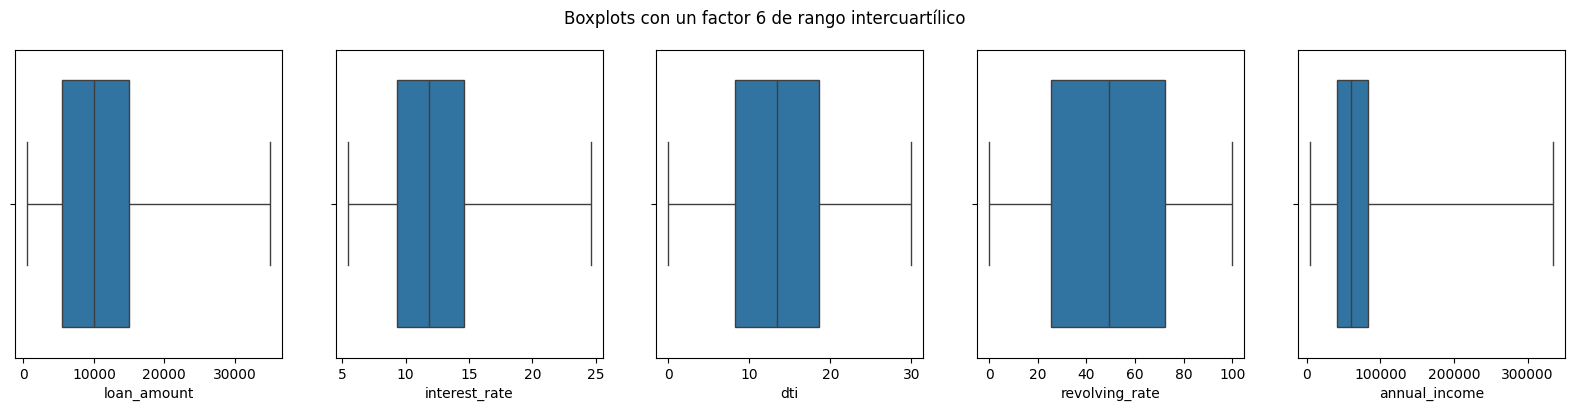

In [39]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas = ['loan_amount', 'interest_rate', 'dti', 'revolving_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots con un factor 6 de rango intercuartílico')
sns.boxplot(ax=axes[0], x=df[columnas_continuas[0]], whis=6)
sns.boxplot(ax=axes[1], x=df[columnas_continuas[1]], whis=6)
sns.boxplot(ax=axes[2], x=df[columnas_continuas[2]], whis=6)
sns.boxplot(ax=axes[3], x=df[columnas_continuas[3]], whis=6)
sns.boxplot(ax=axes[4], x=df[columnas_continuas[4]], whis=6)

plt.show();

Vemos que ahora ya no tenemos outliers extremos

## Análisis

De una primera visualización de la relación entre las diferentes variables de nuestro dataframe no parecen inferirse relaciones claras entre las variables, más allá de que algunas 
distribuciones pudieran ser normales.

In [40]:
variables_continuas = ['loan_amount', 'interest_rate', 'installment', 'dti', 'revolving_rate', 'annual_income']

In [41]:
variables_categoricas = ['id', 'loan_status', 'grade', 'verification_status', 'purpose', 'home_ownership']
variables_categoricas.remove('id')
variables_categoricas

['loan_status', 'grade', 'verification_status', 'purpose', 'home_ownership']

In [42]:
# Variables numéricas discretas
variables_discretas = ['loan_term', 'inquiries', 'open_credit_lines', 'derogatory', 'total_credit_lines', 'employment_length', 'loan_status']

### Análisis Univariante y Bivariante

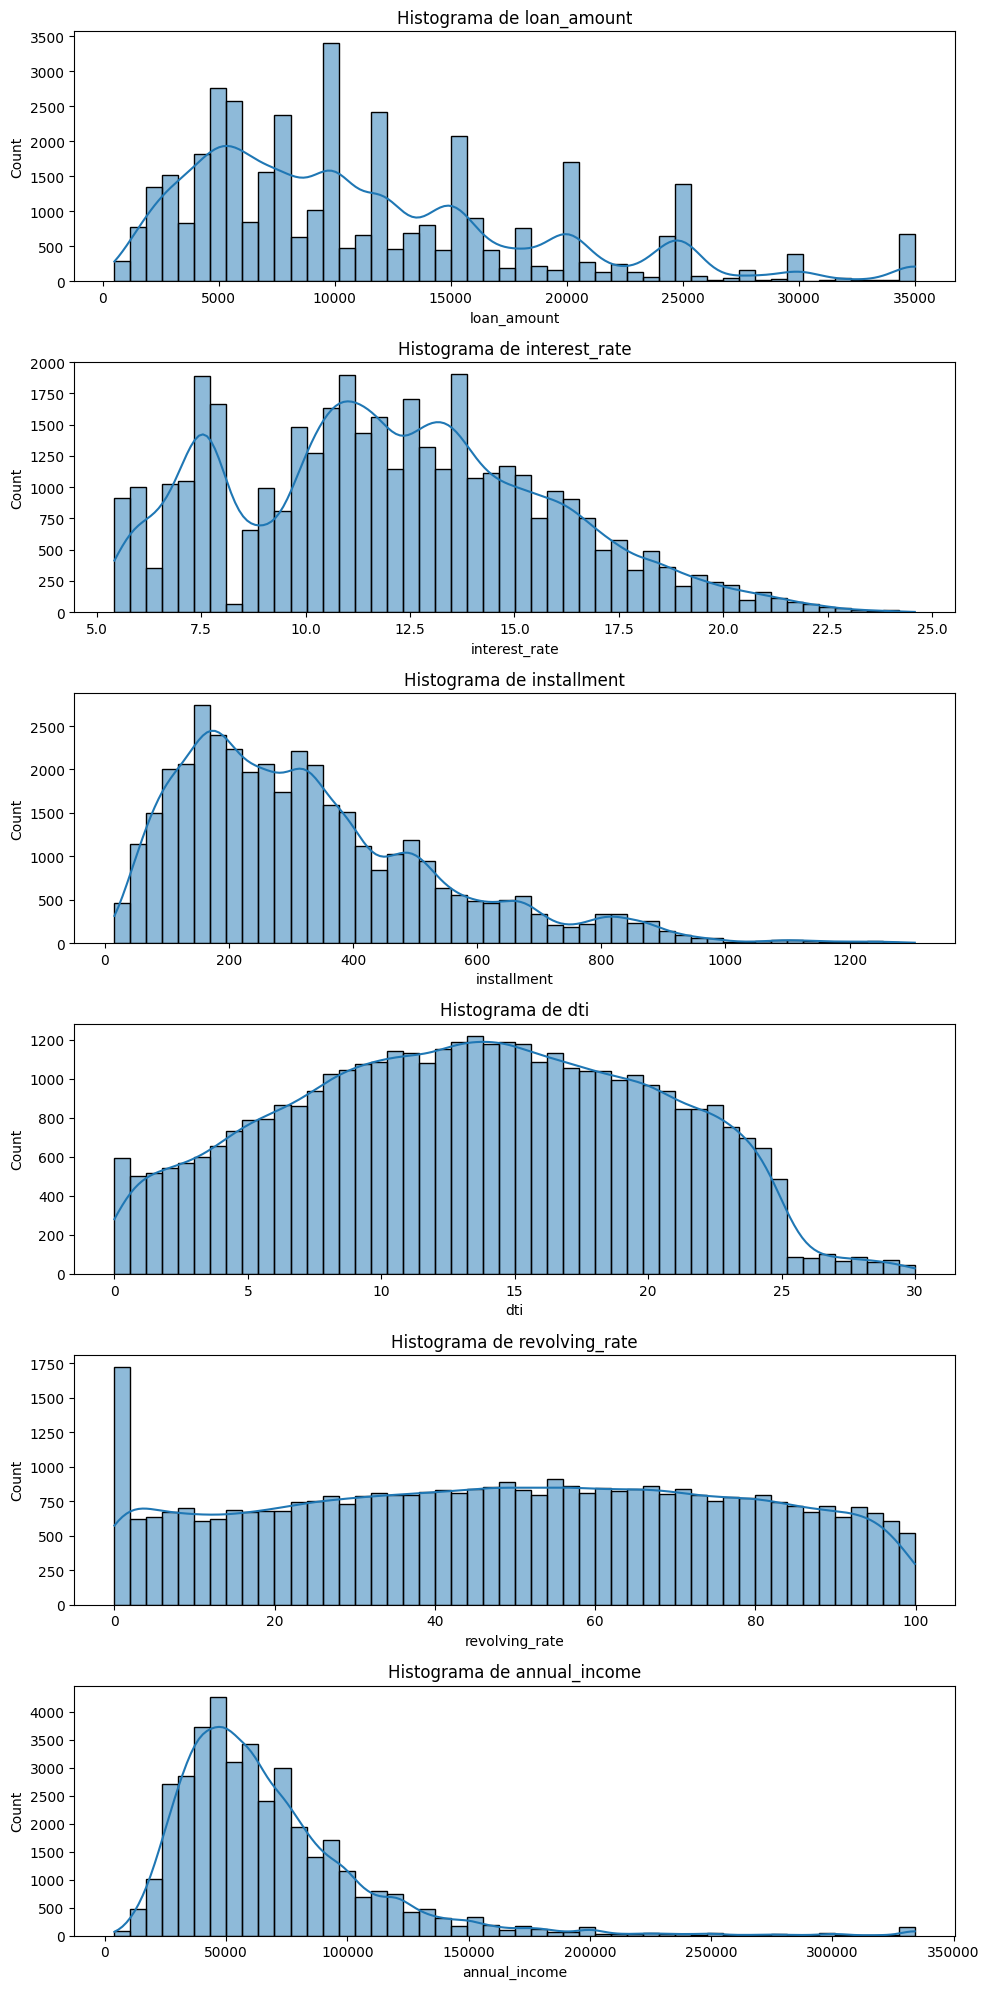

In [43]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_continuas), figsize=(10, 20))

# Iterar sobre las columnas continuas
for i, columna in enumerate(variables_continuas):
    # Histograma con función de densidad de probabilidad
    sns.histplot(df[columna], bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f'Histograma de {columna}')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Las variables 'loan_amount', 'interest_rate', 'installment' y 'annual_income' tienen cierta asimetria, veamos como quedarian con una escala logaritmica

In [44]:
columnas_log = ['loan_amount', 'interest_rate', 'installment', 'annual_income']

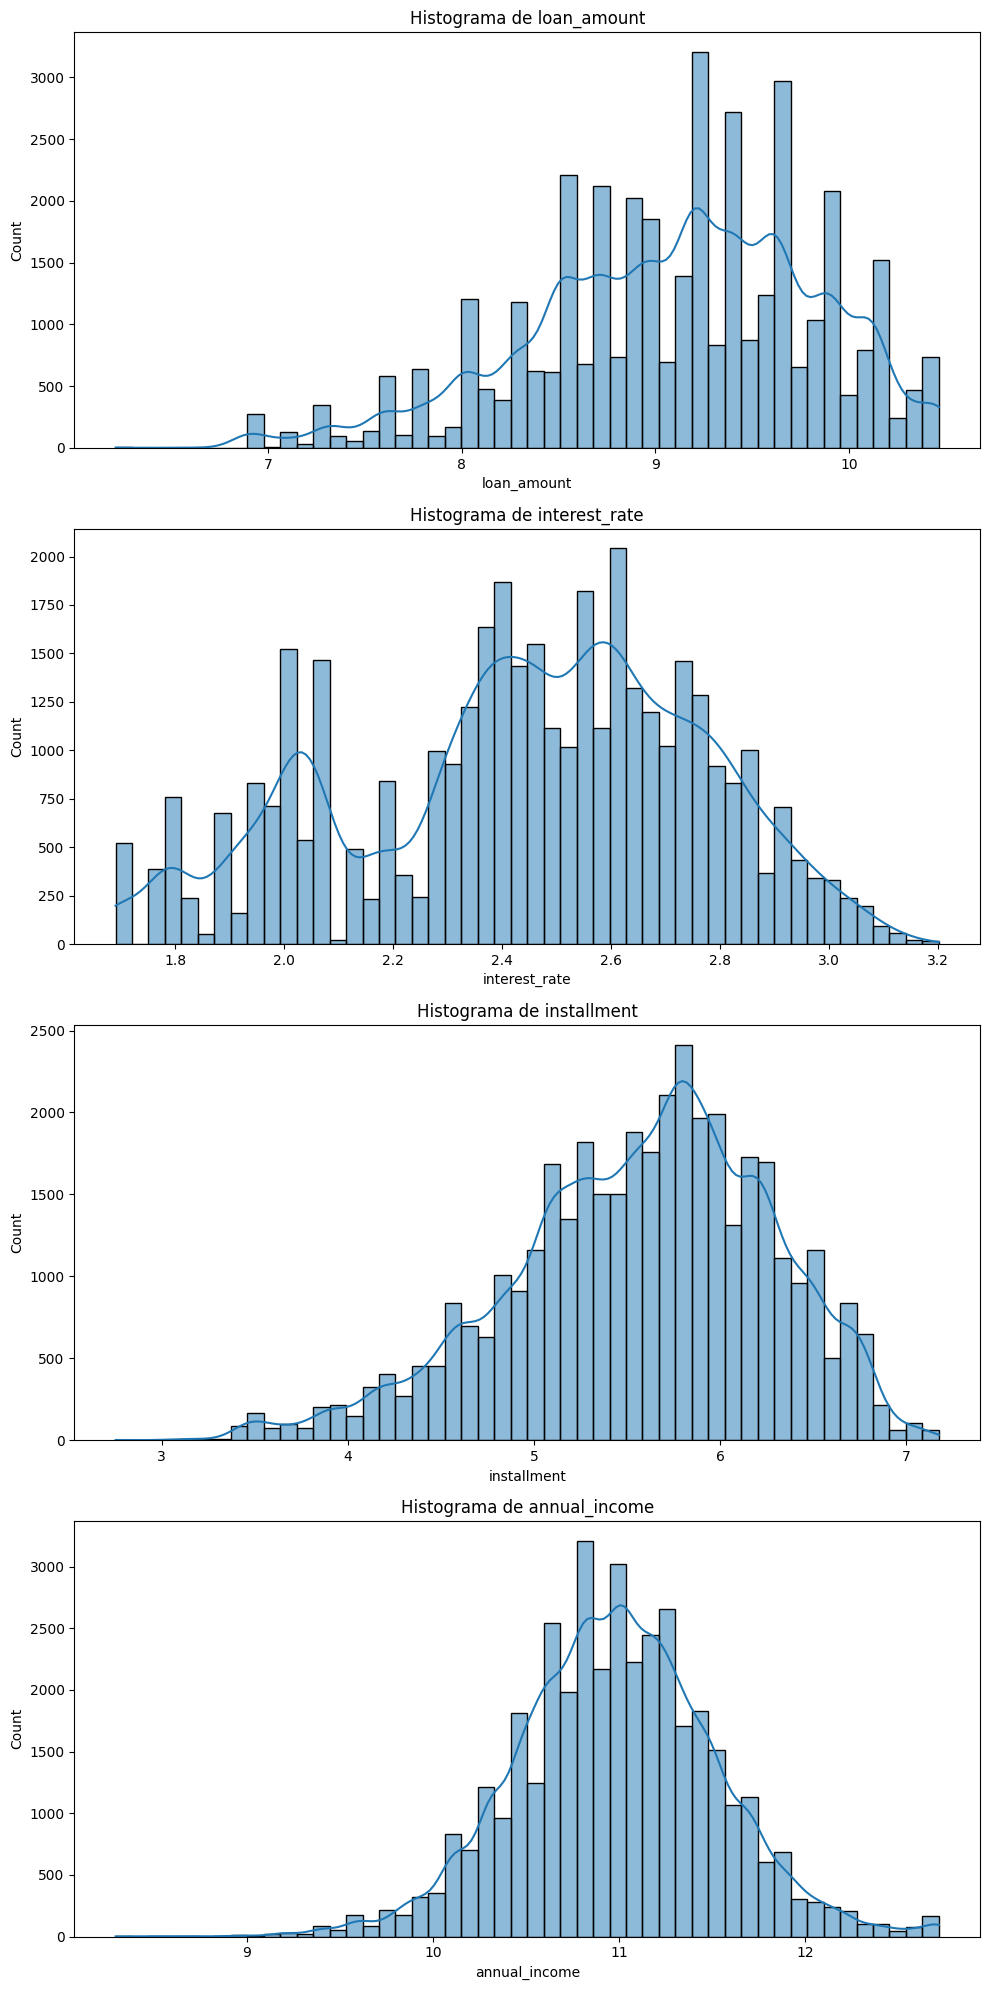

In [45]:
fig, axs = plt.subplots(nrows=len(columnas_log), figsize=(10, 20))

# Iterar sobre las columnas continuas
for i, columna in enumerate(columnas_log):
    # Histograma con función de densidad de probabilidad
    sns.histplot(np.log(df[columna]), bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f'Histograma de {columna}')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Vamos a convertir solo la columna 'annual_income'

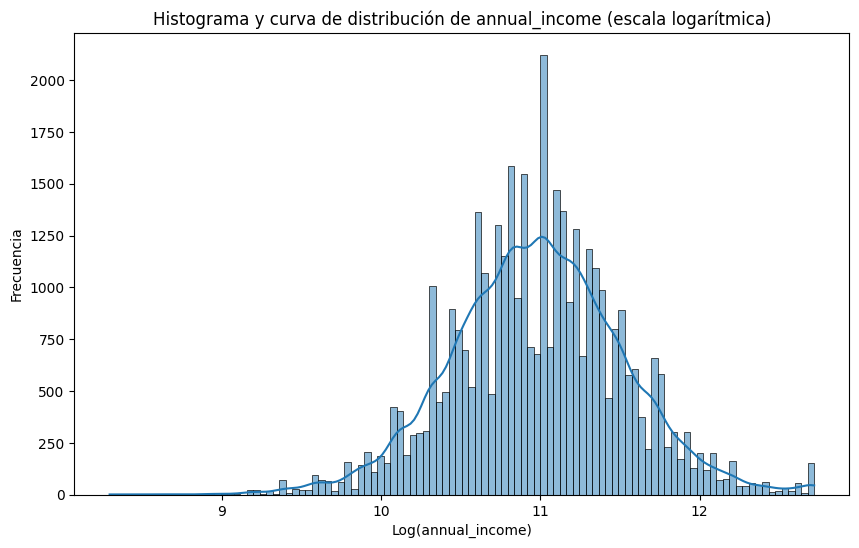

In [46]:
# Escalar 'annual_income' a escala logarítmica
df['annual_income'] = np.log(df['annual_income'])

# Histograma con función de densidad de probabilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['annual_income'], kde=True)
plt.title('Histograma y curva de distribución de annual_income (escala logarítmica)')
plt.xlabel('Log(annual_income)')
plt.ylabel('Frecuencia')
plt.show()

Vamos a analizar ahora las columnas categoricas

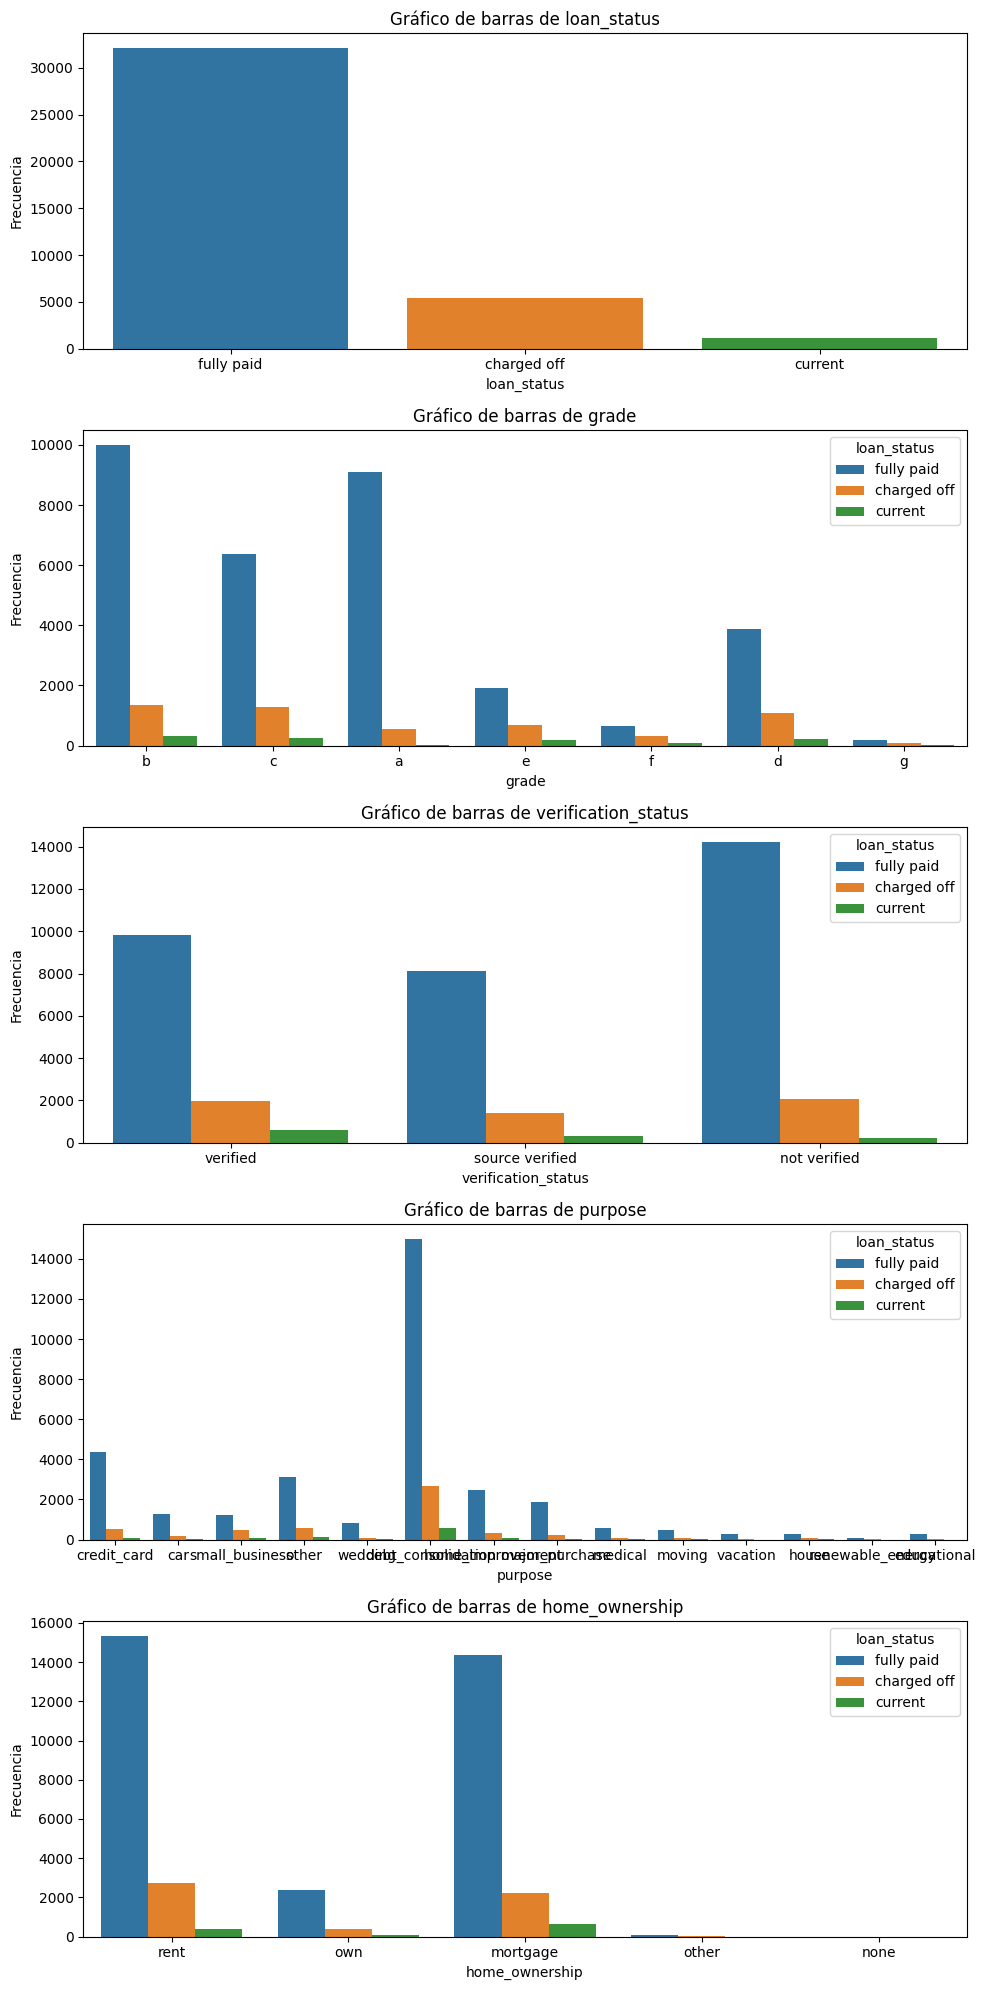

In [47]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_categoricas), figsize=(10, 20))

# Iterar sobre las columnas categóricas
for i, columna in enumerate(variables_categoricas):
    # Gráfico de barras
    sns.countplot(x=columna, data=df, ax=axs[i], hue='loan_status')
    axs[i].set_title(f'Gráfico de barras de {columna}')
    axs[i].set_xlabel(columna)
    axs[i].set_ylabel('Frecuencia')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Vamos ahora con las variables discretas

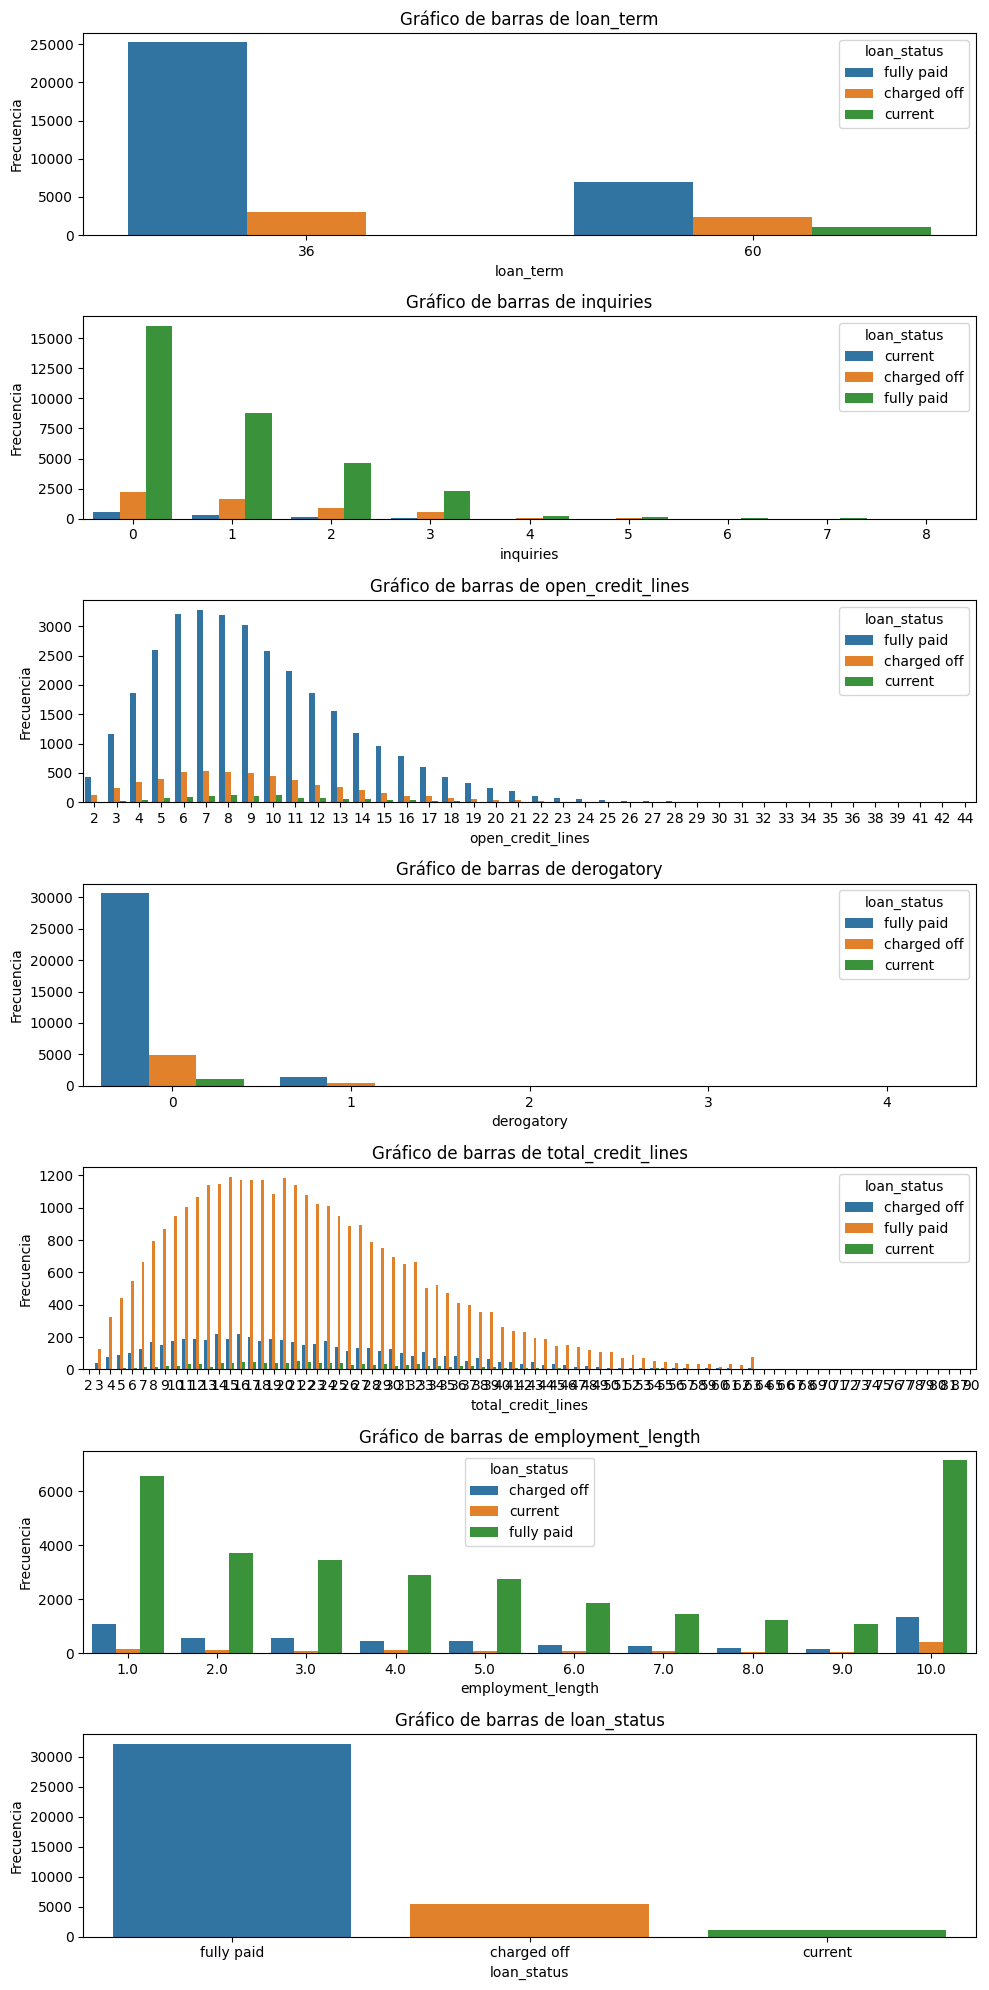

In [48]:
# Crear subplots
fig, axs = plt.subplots(nrows=len(variables_discretas), figsize=(10, 20))

# Iterar sobre las columnas categóricas
for i, columna in enumerate(variables_discretas):
    # Gráfico de barras
    sns.countplot(x=columna, data=df, ax=axs[i], hue='loan_status')
    axs[i].set_title(f'Gráfico de barras de {columna}')
    axs[i].set_xlabel(columna)
    axs[i].set_ylabel('Frecuencia')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

## Análisis Multivariante

Veamos en primer lugar la correlación existente entre las variables numéricas de nuestro dataset

In [49]:
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,id,loan_amount,loan_term,interest_rate,installment,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income
id,1.000000,0.146473,0.223575,0.083189,0.090195,0.095810,-0.041859,0.022344,-0.021260,0.099719,0.043521,0.113486,0.051562
loan_amount,0.146473,1.000000,0.360159,0.307613,0.929744,0.065482,0.009495,0.173790,-0.047820,0.066844,0.255794,0.154473,0.442788
loan_term,0.223575,0.360159,1.000000,0.452545,0.099743,0.084188,0.041437,0.050285,0.009099,0.071972,0.095913,0.113383,0.092209
interest_rate,0.083189,0.307613,0.452545,1.000000,0.280382,0.112549,0.132270,0.012251,0.097358,0.462711,-0.042191,0.005765,0.072166
installment,0.090195,0.929744,0.099743,0.280382,1.000000,0.053055,0.010025,0.169612,-0.043158,0.095824,0.230145,0.124807,0.438816
dti,0.095810,0.065482,0.084188,0.112549,0.053055,1.000000,-0.000275,0.289219,-0.004945,0.278734,0.230755,0.051119,-0.105304
inquiries,-0.041859,0.009495,0.041437,0.132270,0.010025,-0.000275,1.000000,0.092114,0.024579,-0.068584,0.112005,0.008623,0.040956
open_credit_lines,0.022344,0.173790,0.050285,0.012251,0.169612,0.289219,0.092114,1.000000,0.002791,-0.085271,0.685576,0.097383,0.284459
derogatory,-0.021260,-0.047820,0.009099,0.097358,-0.043158,-0.004945,0.024579,0.002791,1.000000,0.058041,-0.020014,0.062175,-0.007810
revolving_rate,0.099719,0.066844,0.071972,0.462711,0.095824,0.278734,-0.068584,-0.085271,0.058041,1.000000,-0.065761,0.012980,0.048950


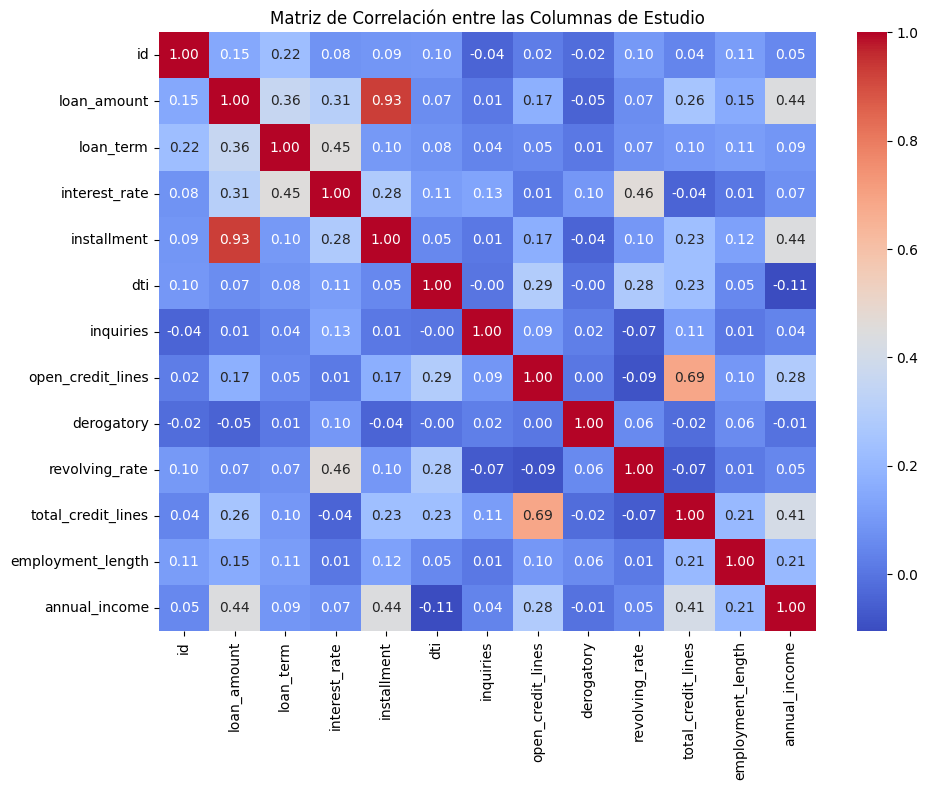

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Columnas de Estudio')
plt.tight_layout()
plt.show()

Como vemos la correlación entre las variables numéricas es muy baja, con la excepción de la correlación entre el importe del préstamo y la cuota pagada (lo cual tiene todo el sentido).

Cabe mencionar alguna relación entre el tipo de interés y la tasa de revolving, entre los ingresos anuales y la cuota pagada, y entre los ingresos anuales y el importe del préstamo

Vemos gráficamente estas relaciones

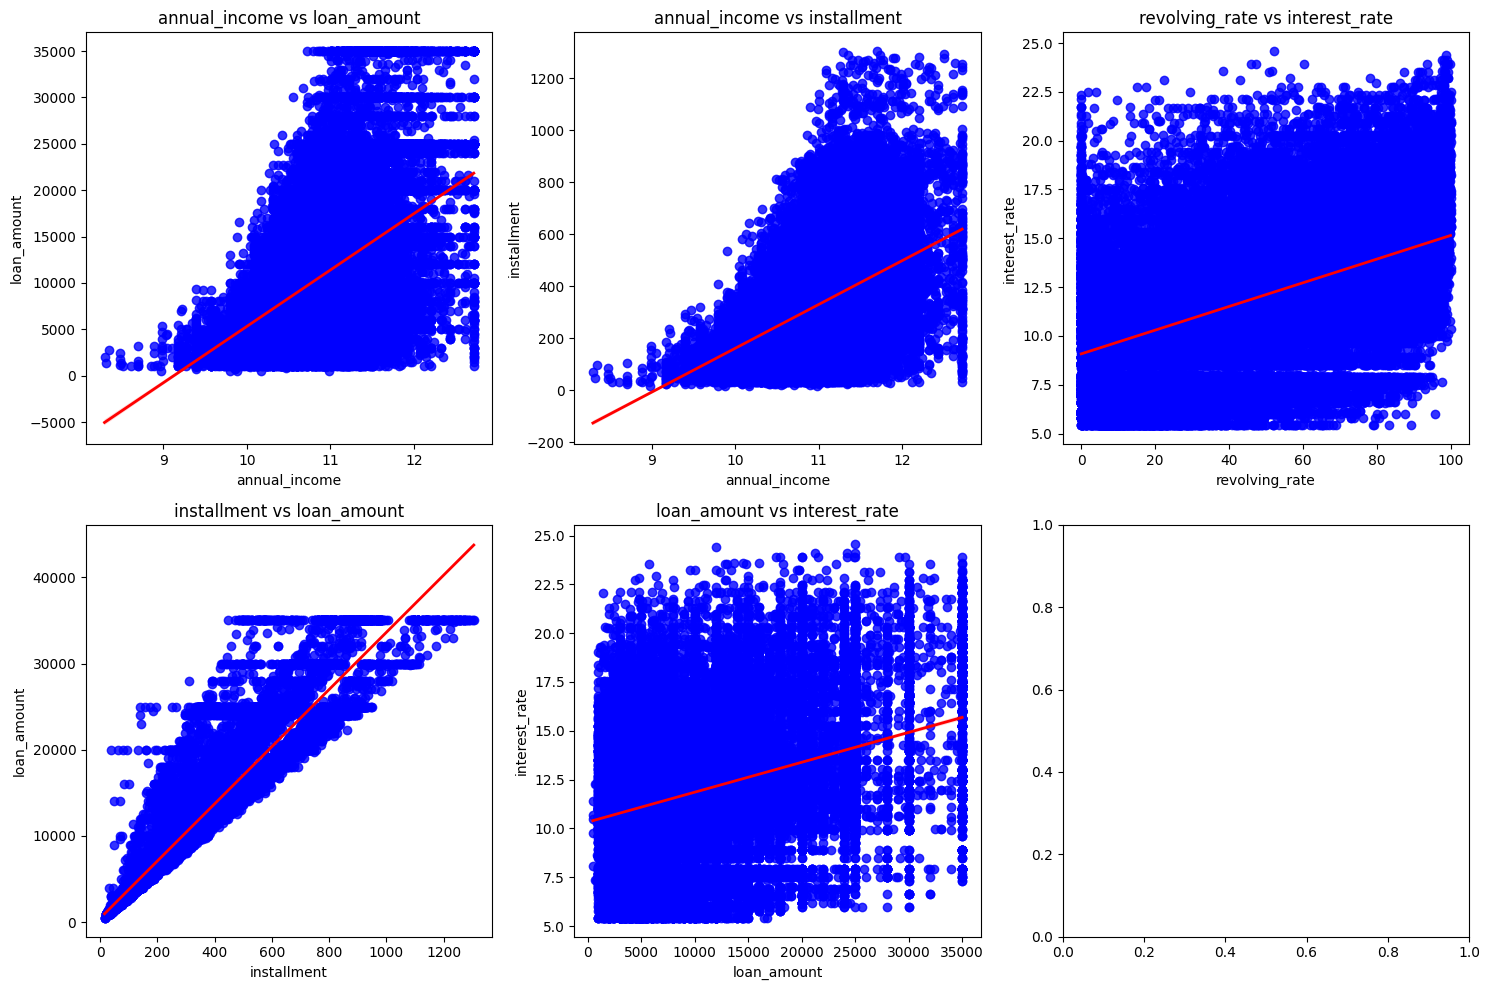

In [51]:
# Definir las columnas para el estudio
columnas_estudio = ['loan_amount', 'interest_rate', 'installment', 'revolving_rate', 'annual_income', 'dti']

# Seleccionar solo las columnas de interés del DataFrame
df_estudio = df[columnas_estudio]

# Crear un subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Definir las combinaciones de columnas y sus posiciones en el subplot
columnas_combinaciones = [
    ('annual_income', 'loan_amount'),
    ('annual_income', 'installment'),
    ('revolving_rate', 'interest_rate'),
    ('installment', 'loan_amount'),
    ('loan_amount', 'interest_rate')
]

# Iterar sobre las combinaciones y trazar gráficos de dispersión con línea de tendencia
for i, combinacion in enumerate(columnas_combinaciones):
    row = i // 3
    col = i % 3
    sns.regplot(x=combinacion[0], y=combinacion[1], data=df_estudio, ax=axs[row, col], scatter_kws={"color": "blue"}, line_kws={"color":"red","linewidth":2})
    axs[row, col].set_title(f'{combinacion[0]} vs {combinacion[1]}')

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

Eliminamos la columna 'installment' por estar muy relacionada con la columna 'loan_amount'

In [57]:
df.drop(columns=['installment'], inplace=True)

Con esto damos por finalizado las transformaciones inicial

In [58]:
df_final_clean = df.copy()
df_final_clean.to_csv('../data/processed/df_final_clean.csv', index=False)

Una vez que tenemos el dataset limpio, vamos a proceder a dividirlo en 2 distinguiendo entre si crédito está todavía en vigor "current" o no
* df_final_current: comprende el dataframe limpio pero con solo con los créditos pagados en vigor
* df_final_no_current: dataframe limpio con todos los créditos ya vencidos


In [64]:
# Mapeamos los valores de 'loan_status' a 1 si es 'charged off' y 0 si es 'fully paid'
df['loan_status'] = df['loan_status'].map({'charged off': 1, 'fully paid': 0})

loan_status
fully paid     32145
charged off     5399
current         1098
Name: count, dtype: int64

In [62]:
df_final_current = df[df['loan_status'] == 'current']
df_final_current.drop(columns='loan_status', inplace=True)
df_final_current.to_csv('../data/processed/df_final_current.csv', index=False)

In [65]:
df_final_due = df[df['loan_status'] != 'current']


In [66]:
# Mapeamos los valores de 'loan_status' a 1 si es 'charged off' y 0 si es 'fully paid'
df_final_due['loan_status'] = df_final_due['loan_status'].map({'charged off': 1, 'fully paid': 0})

In [67]:
df_final_due.to_csv('../data/processed/df_final_due.csv', index=False)

In [68]:
df_final_due.head()

,id,loan_status,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,0,5000,36,10.65,b,verified,credit_card,27.65,1,3,0,83.7,9,10.0,rent,10.085809
1,1077430,1,2500,60,15.27,c,source verified,car,1.00,5,3,0,9.4,4,1.0,rent,10.308953
2,1077175,0,2400,36,15.96,c,not verified,small_business,8.72,2,2,0,98.5,10,10.0,rent,9.413444
3,1076863,0,10000,36,13.49,c,source verified,other,20.00,1,10,0,21.0,37,10.0,rent,10.803649
5,1075269,0,5000,36,7.90,a,source verified,wedding,11.20,3,9,0,28.3,12,3.0,rent,10.491274


El daset 'df_final_current' son los préstamos vigentes, y vamos a tratar de predecir si estos préstamos van a ser pagados o impagados con nuestro modelo de Machine Learning

Con el dataset 'df_final_due' es con el que vamos a entrenar y hacer pruebas para elegir el modelo

In [103]:
df = df_final_due.copy()

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37544 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   37544 non-null  int64  
 1   loan_status          37544 non-null  int64  
 2   loan_amount          37544 non-null  int64  
 3   loan_term            37544 non-null  int64  
 4   interest_rate        37544 non-null  float64
 5   grade                37544 non-null  object 
 6   verification_status  37544 non-null  object 
 7   purpose              37544 non-null  object 
 8   dti                  37544 non-null  float64
 9   inquiries            37544 non-null  int64  
 10  open_credit_lines    37544 non-null  int64  
 11  derogatory           37544 non-null  int64  
 12  revolving_rate       37544 non-null  float64
 13  total_credit_lines   37544 non-null  int64  
 14  employment_length    37544 non-null  float64
 15  home_ownership       37544 non-null  obje

## MACHINE LEARNING ##

In [105]:
df.head(5)

,id,loan_status,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,0,5000,36,10.65,b,verified,credit_card,27.65,1,3,0,83.7,9,10.0,rent,10.085809
1,1077430,1,2500,60,15.27,c,source verified,car,1.00,5,3,0,9.4,4,1.0,rent,10.308953
2,1077175,0,2400,36,15.96,c,not verified,small_business,8.72,2,2,0,98.5,10,10.0,rent,9.413444
3,1076863,0,10000,36,13.49,c,source verified,other,20.00,1,10,0,21.0,37,10.0,rent,10.803649
5,1075269,0,5000,36,7.90,a,source verified,wedding,11.20,3,9,0,28.3,12,3.0,rent,10.491274


Creamos una funcion que nos divida el dataset en el dataset de entrenamiento y el de prueba

In [106]:
def dividir_dataset(df, test_size=0.25, random_state=None, target='loan_status', no_incluir='id'):
    """
    Función para dividir un DataFrame en conjuntos de entrenamiento y prueba.

    Args:
    - df: DataFrame que se desea dividir.
    - test_size: Porcentaje del dataset que se desea asignar al conjunto de prueba. Por defecto, es 0.25.
    - random_state: Semilla para la generación de números aleatorios. Por defecto, es None.

    Returns:
    - train_set: DataFrame de entrenamiento.
    - test_set: DataFrame de prueba.
    """
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=random_state)
    X_train_set = train_set.drop(columns=[no_incluir, target])
    X_test_set = test_set.drop(columns=[no_incluir, target])
    y_train_set = train_set[target]
    y_test_set = test_set[target]
    return X_train_set, X_test_set, y_train_set, y_test_set

In [87]:
X_train, X_test, y_train, y_test = dividir_dataset(df, test_size=0.25, random_state=42)

# Imprimir tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 28158
Tamaño del conjunto de prueba: 9386


In [108]:
X_train.head(5)

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
3428,20800,60,10.65,b,verified,debt_consolidation,14.66,0,7,0,29.4,18,5.0,mortgage,10.621327
17712,25000,60,13.06,c,verified,debt_consolidation,12.53,1,18,0,41.1,55,5.0,mortgage,12.072541
14155,1550,36,7.49,a,not verified,home_improvement,24.87,0,7,0,0.5,10,5.0,mortgage,9.998798
9811,21000,60,20.25,f,verified,small_business,13.14,0,13,0,73.5,37,10.0,mortgage,11.264464
6084,1200,36,8.90,a,not verified,vacation,9.15,2,9,1,23.5,15,10.0,rent,11.350407


In [109]:
X_test.head(5)

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
38883,25000,36,13.24,d,not verified,other,15.62,3,12,0,62.3,47,10.0,mortgage,12.206073
21439,3600,36,6.17,a,source verified,debt_consolidation,3.28,1,8,0,5.3,17,1.0,rent,10.308953
28221,8500,36,6.76,a,source verified,major_purchase,15.89,0,16,0,8.7,45,2.0,mortgage,10.831707
31733,20000,36,13.85,c,not verified,other,8.17,2,14,0,86.3,47,10.0,mortgage,12.718896
28045,8000,36,15.58,d,not verified,debt_consolidation,24.09,1,11,0,74.3,21,10.0,mortgage,10.896739


In [111]:
X_test

,loan_amount,loan_term,interest_rate,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
38883,25000,36,13.24,d,not verified,other,15.62,3,12,0,62.3,47,10.0,mortgage,12.206073
21439,3600,36,6.17,a,source verified,debt_consolidation,3.28,1,8,0,5.3,17,1.0,rent,10.308953
28221,8500,36,6.76,a,source verified,major_purchase,15.89,0,16,0,8.7,45,2.0,mortgage,10.831707
31733,20000,36,13.85,c,not verified,other,8.17,2,14,0,86.3,47,10.0,mortgage,12.718896
28045,8000,36,15.58,d,not verified,debt_consolidation,24.09,1,11,0,74.3,21,10.0,mortgage,10.896739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30580,23500,36,11.36,b,not verified,wedding,16.10,0,9,0,52.4,27,5.0,rent,11.267025
22801,10000,36,9.25,b,not verified,debt_consolidation,18.77,1,7,0,59.9,20,3.0,rent,10.968129
8924,35000,60,17.99,e,verified,debt_consolidation,14.57,3,15,0,66.3,31,2.0,rent,11.445717
29029,10000,36,10.38,b,verified,home_improvement,0.90,1,5,0,42.7,33,9.0,own,12.611538


Creamos unas listas con las variables categoricas y numericas

In [119]:
# Definir las columnas categóricas y numéricas
categorical_cols = ['grade', 'verification_status', 'purpose', 'home_ownership']
numeric_cols = ['loan_amount', 'loan_term', 'interest_rate', 'dti', 'inquiries', 'open_credit_lines',
                'derogatory', 'revolving_rate', 'total_credit_lines', 'employment_length', 'annual_income']

In [120]:
# Crear el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Crear el pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar el pipeline al conjunto de datos de entrenamiento y prueba
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Obtener los nombres de las columnas después de la transformación OneHotEncoder
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_cols)

# Combinar los nombres de columnas numéricas y categóricas
transformed_feature_names = list(numeric_cols) + list(ohe_feature_names)

# Convertir la salida a DataFrame de pandas
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

In [121]:
X_train_transformed_df.head(5)

,loan_amount,loan_term,interest_rate,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income,grade_a,grade_b,grade_c,grade_d,grade_e,grade_f,grade_g,verification_status_not verified,verification_status_source verified,verification_status_verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,1.321556,1.737068,-0.356070,0.208837,-0.814342,-0.519457,-0.225667,-0.679730,-0.355161,-0.015913,-0.654655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.893931,1.737068,0.295563,-0.110843,0.120594,1.980162,-0.225667,-0.267503,2.885826,-0.015913,2.017324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.301830,-0.575683,-1.210493,1.741198,-0.814342,-0.519457,-0.225667,-1.697967,-1.055916,-0.015913,-1.800859,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.348812,1.737068,2.239645,-0.019292,-0.814342,0.843972,-0.225667,0.874050,1.309130,1.457039,0.529490,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.349528,-0.575683,-0.829247,-0.618129,1.055530,-0.064980,4.056219,-0.887606,-0.617944,1.457039,0.687728,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [122]:
X_test_transformed_df.head(5)

,loan_amount,loan_term,interest_rate,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income,grade_a,grade_b,grade_c,grade_d,grade_e,grade_f,grade_g,verification_status_not verified,verification_status_source verified,verification_status_verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,1.893931,-0.575683,0.344232,0.352918,1.990466,0.616734,-0.225667,0.479439,2.185072,1.457039,2.263182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.022457,-0.575683,-1.567404,-1.499124,0.120594,-0.292218,-0.225667,-1.528848,-0.442756,-1.194274,-1.229800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.354686,-0.575683,-1.407875,0.393440,-0.814342,1.525686,-0.225667,-1.409056,2.009884,-0.899684,-0.267304,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.212532,-0.575683,0.509168,-0.765211,1.055530,1.071210,-0.225667,1.325034,2.185072,1.457039,3.207394,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.422826,-0.575683,0.976938,1.624133,0.120594,0.389496,-0.225667,0.902237,-0.092379,1.457039,-0.147566,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [123]:
X_train_transformed_df.shape

(28158, 40)

In [124]:
X_test_transformed_df.shape

(9386, 40)

### Cross-Validation + Base-Lines ###

In [ ]:
modelos = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False)
    
}

# Define las métricas a usar
metricas = ["accuracy", "f1", "recall" "roc_auc"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train_sca_ohe, y_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict])